# Results Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files()

In [ ]:
get_any(results)

_Result(timestamp=1609607147, cmdline=['/auto/users/andsch/github/active_learning_redux/batchbald_redux/bald_experiment.py', '--id', '4'], commit='be2bb7395d2745e9e3518a5baf8a76fe1c5564b8', github_url='be2bb7395d2745e9e3518a5baf8a76fe1c5564b8', experiment='/auto/users/andsch/github/active_learning_redux/batchbald_redux/bald_experiment.py', job_id=4, worker_id=4, num_workers=15, config=_config(seed=5, acquisition_size=10, max_training_set=300, num_pool_samples=20, num_eval_samples=4, num_training_samples=1, num_patience_epochs=3, max_training_epochs=10, validation_set_size=4096, initial_set_size=20, samples_per_epoch=24576, repeated_mnist_repetitions=2, add_dataset_noise=True), log=_log(), initial_training_set_indices=[64464, 41731, 12238, 12225, 79821, 88909, 34591, 101788, 62540, 74910, 35191, 97065, 30964, 50522, 39272, 106667, 10530, 21538, 88392, 99555], active_learning_steps=[_ActiveLearningStepsItem(training=_training(epochs=[_EpochsItem(accuracy=0.636962890625, crossentropy=2.92

In [ ]:
experiment_data = []

for file, result in results.items():
    if "bald_ical" in file:
        acquisition_function = "BatchBALD-ICAL"
    elif "randombald" in file:
        acquisition_function = "RandomBALD"
    elif "thompsonbald" in file:
        acquisition_function = "ThompsonBALD"
    elif "batchbald" in file:
        acquisition_function = "BatchBALD"
    else:
        acquisition_function = "BALD"

    acquisition_size = result.config.acquisition_size

    initial_set_size = len(result.initial_training_set_indices)
    for i, step in enumerate(result.active_learning_steps):
        training_set_size = initial_set_size + i * result.config.acquisition_size
        accuracy = step.evalution_metrics.accuracy

        experiment_data.append(
            dict(
                acquisition_function=acquisition_function,
                acquisition_size=acquisition_size,
                training_set_size=training_set_size,
                accuracy=accuracy,
            )
        )

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,acquisition_function,acquisition_size,training_set_size,accuracy
0,BALD,10,20,0.6502
1,BALD,10,30,0.6893
2,BALD,10,40,0.7337
3,BALD,10,50,0.7697
4,BALD,10,60,0.8055
...,...,...,...,...
2080,BatchBALD,5,280,0.9414
2081,BatchBALD,5,285,0.9466
2082,BatchBALD,5,290,0.9506
2083,BatchBALD,5,295,0.9608


In [ ]:
import seaborn as sns

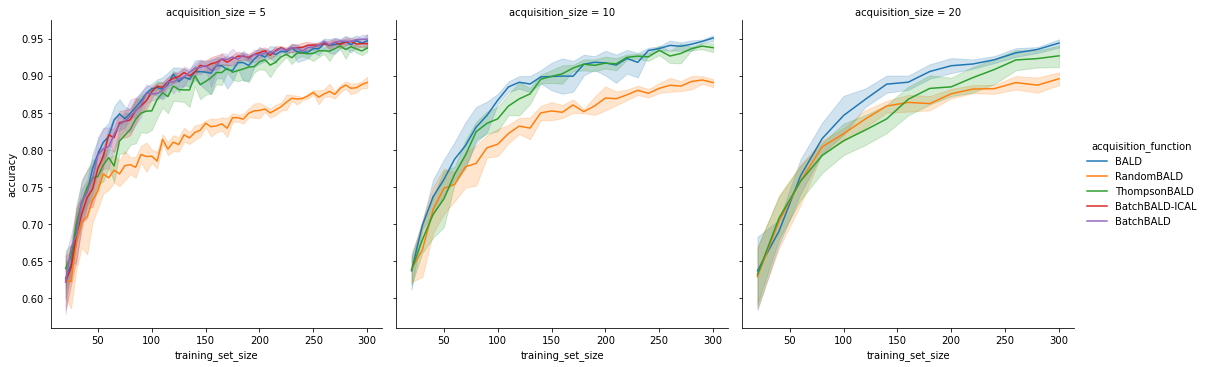

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
import plotnine as p9

In [ ]:
plot = p9.ggplot(
    df,
    p9.aes(
        x="training_set_size",
        y="accuracy",
        color="acquisition_function",
        fill="acquisition_function",
        linetype="acquisition_size",
    ),
)

plot += p9.stat_summary(
    fun_data="median_hilow", fun_args={"confidence_interval": 0.95}, geom="smooth", size=1, alpha=0.25
)

# plot += p9.geom_point(alpha=0.5, size=0.25)

# plot += p9.scale_color_manual(name="Acquisition Function", values=["green", "blue"])
# plot += p9.scale_fill_manual(name="Acquisition Function", values=["green", "blue"])

plot

PlotnineError: 'Aesthetics cannot vary within a ribbon.'